In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Upload data
from zipfile import ZipFile
file_name = '/content/drive/My Drive/Foliar Disease Classification.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import os
from re import search
import shutil
import natsort

from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

import cv2

In [ ]:
DIR = r'/content/Foliar Disease Classification/images'

In [ ]:
train = pd.read_csv('/content/Foliar Disease Classification/labels/train.csv')
test = pd.read_csv(r'/content/Foliar Disease Classification/labels/test.csv')

In [ ]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


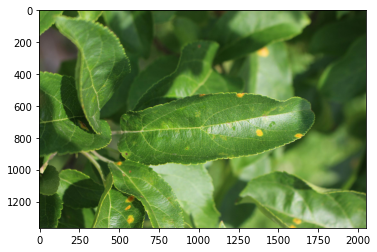

In [ ]:
image1 = Image.open(r'/content/Foliar Disease Classification/images/Test_0.jpg')
plt.imshow(image1)
plt.show()

#Preparing Training Data

In [ ]:
class_names = train.loc[:,'healthy':].columns
print(class_names)

Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')


In [ ]:
number = 0
train['label'] = 0
for i in class_names:
    train['label'] = train['label'] + train[i]*number
    number = number+1

In [ ]:
train

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0
...,...,...,...,...,...,...
1816,Train_1816,0,0,0,1,3
1817,Train_1817,1,0,0,0,0
1818,Train_1818,1,0,0,0,0
1819,Train_1819,0,0,1,0,2


#Creating Seperate Data

In [ ]:
#Code to make directories for different categories. Uncomment the below code to make directories

shutil.os.mkdir(r'/content/Foliar Disease Classification/images/train')
shutil.os.mkdir(r'/content/Foliar Disease Classification/images/train/healthy')
shutil.os.mkdir(r'/content/Foliar Disease Classification/images/train/Multiple_diseases')
shutil.os.mkdir(r'/content/Foliar Disease Classification/images/train/Rust')
shutil.os.mkdir(r'/content/Foliar Disease Classification/images/train/Scab')

shutil.os.mkdir(r'/content/Foliar Disease Classification/images/test')

In [ ]:
def get_label_img(img):
    if search("Train",img):
        img=img.split('.')[0]
        label=train.loc[train['image_id']==img]['label']
        return label

In [ ]:
def create_train_data():
    images=natsort.natsorted(os.listdir(DIR))
    for img in tqdm(images):
        label=get_label_img(img)
        path=os.path.join(DIR,img)
        
        if search("Train",img):
            if (img.split("_")[1].split(".")[0]) and label.item()==0:
                shutil.copy(path,r'/content/Foliar Disease Classification/images/train/healthy')
            
            elif(img.split("_")[1].split(".")[0]) and label.item()==1:
                shutil.copy(path,r'/content/Foliar Disease Classification/images/train/Multiple_diseases')
                
            elif(img.split("_")[1].split(".")[0]) and label.item()==2:
                shutil.copy(path,r'/content/Foliar Disease Classification/images/train/Rust')
                
            elif(img.split("_")[1].split(".")[0]) and label.item()==3:
                shutil.copy(path,r'/content/Foliar Disease Classification/images/train/Scab')
                
        elif search("Test",img):
            shutil.copy(path,r'/content/Foliar Disease Classification/images/test')

In [ ]:
train_dir = create_train_data()

100%|██████████| 3644/3644 [00:02<00:00, 1217.95it/s]


#Data Preprocessing

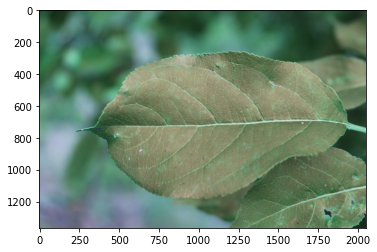

In [ ]:
Train_DIR = r'/content/Foliar Disease Classification/images/train'
Categories = ['healthy', 'Multiple_diseases','Rust', 'Scab']

for j in Categories:
    path = os.path.join(Train_DIR,j)
    
    for k in os.listdir(path):
        old_image = cv2.imread(os.path.join(path,k), cv2.COLOR_BGR2RGB)
        plt.imshow(old_image)
        plt.show()
        break
    break

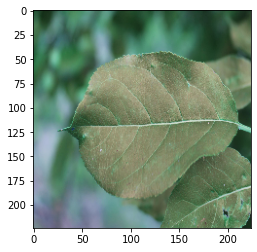

In [ ]:
# Resizing the image size

IMG_SIZE = 224
new_image = cv2.resize(old_image,(IMG_SIZE, IMG_SIZE ))
plt.imshow(new_image)
plt.show()

#Model Preparation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2, 
                               horizontal_flip = True,
                               vertical_flip = True,
                               validation_split = 0.2)

train_datagen = datagen.flow_from_directory(r'/content/Foliar Disease Classification/images/train',
                                           target_size = (IMG_SIZE, IMG_SIZE),
                                           batch_size = 16,
                                           class_mode = 'categorical',
                                           subset = 'training')

validation_datagen = datagen.flow_from_directory(r'/content/Foliar Disease Classification/images/train',
                                           target_size = (IMG_SIZE, IMG_SIZE),
                                           batch_size = 16,
                                           class_mode = 'categorical',
                                           subset = 'validation')

Found 1458 images belonging to 4 classes.
Found 363 images belonging to 4 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(64,(3,3), activation = 'relu', padding = 'same', input_shape = (IMG_SIZE, IMG_SIZE,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3), activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128,(3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(4,activation='softmax'))

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

In [ ]:
checkpoint=ModelCheckpoint(r'/content/Foliar Disease Classification/model/foliar_model3.h5',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [ ]:
model_history=model.fit_generator(train_datagen,validation_data=validation_datagen,
                                 epochs=30,
                                 steps_per_epoch=train_datagen.samples//16,
                                 validation_steps=validation_datagen.samples//16,
                                 callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
91/91 [==============================] - 74s 810ms/step - loss: 1.2483 - accuracy: 0.3460 - val_loss: 1.2302 - val_accuracy: 0.3295

Epoch 00001: val_loss improved from inf to 1.23022, saving model to /content/Foliar Disease Classification/model/foliar_model3.h5
Epoch 2/30
91/91 [==============================] - 74s 814ms/step - loss: 1.1715 - accuracy: 0.4702 - val_loss: 1.1399 - val_accuracy: 0.4659

Epoch 00002: val_loss improved from 1.23022 to 1.13986, saving model to /content/Foliar Disease Classification/model/foliar_model3.h5
Epoch 3/30
91/91 [==============================] - 73s 803ms/step - loss: 0.9176 - accuracy: 0.6214 - val_loss: 0.7296 - val_accuracy: 0.7244

Epoch 00003: val_loss improved from 1.13986 to 0.72961, saving model to /content/Foliar Disease Classification/model/foliar_model3.h5
Epoch 4/30
91/91 [==============================] - 73s 806ms/step - loss: 0.7371 - accuracy: 0.7067 - val_loss: 0.6990 - val_accuracy: 0.7017

Epoch 00004: val_loss impr

#Analysis of model

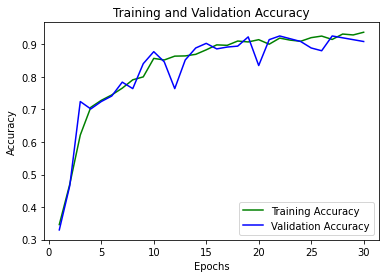

In [ ]:
acc_train=model_history.history['accuracy']
acc_val=model_history.history['val_accuracy']
epochs=range(1,31)
plt.plot(epochs, acc_train,'g',label='Training Accuracy')
plt.plot(epochs, acc_val,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


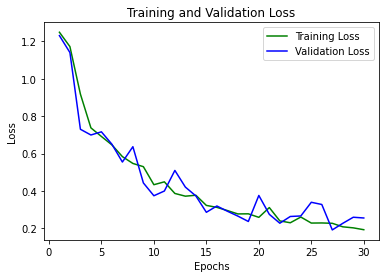

In [ ]:
loss_train=model_history.history['loss']
loss_val=model_history.history['val_loss']
epochs=range(1, 31)
plt.plot(epochs,loss_train,'g',label='Training Loss')
plt.plot(epochs,loss_val,'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Making prediction on single image

1


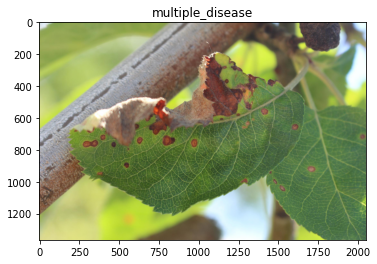

In [ ]:
test_image=r'/content/Foliar Disease Classification/images/train/Multiple_diseases/Train_1.jpg'
image_result=Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image=image.load_img(test_image, target_size=(224,224))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)
print(np.argmax(result))
Categories=['healthy', 'multiple_disease', 'rust', 'scab']
image_result=plt.imshow(image_result)
plt.title(Categories[np.argmax(result)])
plt.show()
